In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import scipy
import plotly
from plotly import graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
import networkx as nx
# importing librarys

In [86]:
def parseData(file):
    import csv
    Data =[]
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for lines in csv_reader:
           Data.append(lines)
        mainRootPoints =[]
        c=1
        while len(Data[c]) != 1:
            point = [float(Data[c][0]),float(Data[c][1])]
            mainRootPoints.append(point)
            c= c+1
        pqs =[]
        pq=[]
        c=c+1
        while c < len(Data):
            if len(Data[c]) ==1:
                pqs.append(pq)
                pq =[]
            if len(Data[c]) ==2:
                point = [float(Data[c][0]),float(Data[c][1])]
                pq.append(point)
            c = c+1
        pqs.append(pq)
    return (mainRootPoints, pqs)
#Making the data into readable segments

In [120]:
def readArborFile(fileName):
    Array = parseData(fileName)
    mainRootPoints = Array[0]
    lateralRoots =Array[1]
    Plant = nx.Graph()
    #adding the mainroot base to graph
    Plant.add_node(0)
    Plant._node[0]['label']= 'main root base'
    Plant._node[0]['coordinate'] = [mainRootPoints[0][0], mainRootPoints[0][1]]
    #constructing the main root
    for i in range(1, len(mainRootPoints)):
        Plant.add_node(i)
        Plant._node[i]['label']= 'main root'
        Plant._node[i]['coordinate'] = (mainRootPoints[i][0], mainRootPoints[i][1])
        Plant.add_edge(i-1,i)
        Plant[i-1][i]['label'] = 'main root'
        Plant[i-1][i]['G'] = 0
    #this way we can have individual labels for points
    count = len(mainRootPoints)
    #constructing the lateral roots
    for root in lateralRoots:
        # constructing a lateral root
        #making the first point
        Plant.add_node(count)
        Plant._node[count]['label'] = 'lateral root'
        Plant._node[count]['coordinate'] = (root[0][0],root[0][1])
        #making the inside points and edges
        for i in range(1,len(root) -1):
            c =count +i
            Plant.add_node(c)
            Plant._node[c]['label'] = 'lateral root'
            Plant._node[c]['coordinate'] = (root[i][0],root[i][1])
            Plant.add_edge(c-1,c)
            Plant[c-1][c]['label'] = 'lateral root'
            Plant[c-1][c]['G']=0
        #making the root tip
        count = count +len(root)-1
        Plant.add_node(count)
        Plant._node[count]['label'] = 'lateral root tip'
        Plant._node[count]['coordinate'] = (root[-1][0],root[-1][1])
        Plant.add_edge(count-1,count)
        Plant[count-1][count]['label'] = 'lateral root'
        Plant[count-1][count]['G'] =0
        count = count+1
    # return a networkX graph of the arbor
    return Plant

In [126]:
def optimalArbor(arbor, G, alpha):
    MainRootPoints = []
    pqs=[]
    Plant = nx.Graph()
    c=0
    for node in arbor.nodes():
        x, y = arbor.nodes[node]['coordinate']
        if 'main root base' == arbor.nodes[node]['label']:
            MainRootPoints.append([x,y])
            Plant.add_node(c)
            Plant._node[c]['label'] = arbor.nodes[node]['label']
            Plant._node[c]['coordinate'] = arbor.nodes[node]['coordinate']
            print(Plant.nodes.data())
            c = c+1
        elif 'main root' == arbor.nodes[node]['label']:
            MainRootPoints.append([x,y])
            Plant.add_node(c)
            Plant._node[c]['label'] = arbor.nodes[node]['label']
            Plant._node[c]['coordinate'] = arbor.nodes[node]['coordinate']
            Plant.add_edge(c-1,c)
            Plant[c-1][c]['label'] = 'main root'
            Plant[c-1][c]['G'] =0
            c = c+1
        elif 'lateral root tip' == arbor.nodes[node]['label']:
            pqs.append([x,y])
            Plant.add_node(c)
            Plant._node[c]['label'] = arbor.nodes[node]['label']
            Plant._node[c]['coordinate'] = arbor.nodes[node]['coordinate']
            c = c+1
    for pq in pqs:
        Array =findMostOptimal(MainRootPoints,G, alpha,pq) #NEED TO MAKE returen [txy,xs,ys]
        txy =Array[0]
        xs=Array[1]
        ys=Array[2]
        Plant.add_node(c)
        Plant._node[c]['label']='optimal'
        Plant._node[c]['coordinate'] = txy
        Plant._node[c]['pq'] = pq
        for node in Plant.nodes():
            if 'lateral root tip' == Plant.nodes[node]['label']:
                if pq == Plant.nodes[node]['coordinate']:
                    Plant.add_edge(c, node)
                    Plant[c][node]['label'] ='lateral root'
                    Plant[c][node]['G'] = G
                    Plant[c][node]['xs'] = xs
                    Plant[c][node]['ys']= ys
                    break
        c=c+1
    return Plant
    # arbor is a networkx graph
    # return a networkx graph representing optimal arbor

In [125]:
def drawArbor(arbor):
    MainXs=[]
    MainYs=[]
    LateralXs=[]
    LateralYs=[]
    optX =[]
    optY=[]
    for node in arbor.nodes():
        x, y = arbor.nodes[node]['coordinate']
        if 'main root base' == arbor.nodes[node]['label']:
            baseX, baseY = x,y
        elif 'main root' == arbor.nodes[node]['label']:
            MainXs.append(x)
            MainYs.append(y)
        elif 'optimal' == arbor.nodes[node]['label']:
            optX.append(x)
            optY.append(y)
        else:
            LateralXs.append(x)
            LateralYs.append(y)
    node_mainBase =go.Scatter(x =[baseX], y = [baseY], mode='markers', name= 'main root base')
    node_main= go.Scatter(x = MainXs, y = MainYs, mode = 'markers', name = 'main root points')
    node_lateral = go.Scatter(x = LateralXs, y =LateralYs, mode = 'markers', name = 'lateral root points')
    node_opt = go.Scatter(x=optX, y= optY, mode= 'markers', name = 'optimal connections')
    MainXs=[]
    MainYs=[]
    LateralXs=[]
    LateralYs=[]
    for edge in arbor.edges():
        if 'main root' == arbor.edges[edge]['label']:
            x0, y0 = arbor.nodes[edge[0]]['coordinate']
            x1, y1 = arbor.nodes[edge[1]]['coordinate']
            MainXs.append(x0)
            MainXs.append(x1)
            MainXs.append(None)
            MainYs.append(y0)
            MainYs.append(y1)
            MainYs.append(None)
        elif 0 != arbor.edges[edge]['G']:
            if 'optimal' == arbor.nodes[edge[0]]['label']:
                xs = arbor.nodes[edge[0]]['xs']
                ys = arbor.nodes[edge[0]]['ys']
            else:
                xs = arbor.nodes[edge[1]]['xs']
                ys = arbor.nodes[edge[1]]['ys']
            for x in xs:
                LateralXs.append(x)
            LateralXs.append(None)
            for y in ys:
                LateralYs.append(y)
            LateralYs.append(None)
        else:
            x0, y0 = arbor.nodes[edge[0]]['coordinate']
            x1, y1 = arbor.nodes[edge[1]]['coordinate']
            LateralXs.append(x0)
            LateralXs.append(x1)
            LateralXs.append(None)
            LateralYs.append(y0)
            LateralYs.append(y1)
            LateralYs.append(None)
    edge_main = go.Scatter(x = MainXs, y =MainYs, mode = 'lines', name ='main root')
    edge_lateral = go.Scatter(x = LateralXs, y= LateralYs, mode='lines', name = 'lateral root')
    Array = [node_mainBase,node_main, node_opt, node_lateral,edge_main,edge_lateral]
    return Array
    # arbor is a networkx graph
    # draw the arbor in plotly

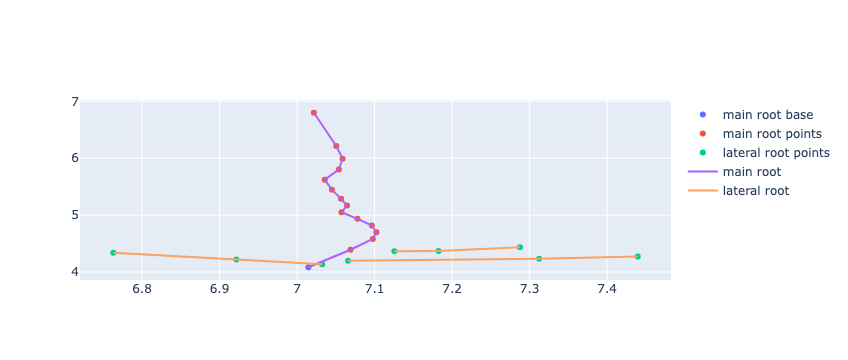

[(0, {'label': 'main root base', 'coordinate': [7.014674, 4.083105]})]


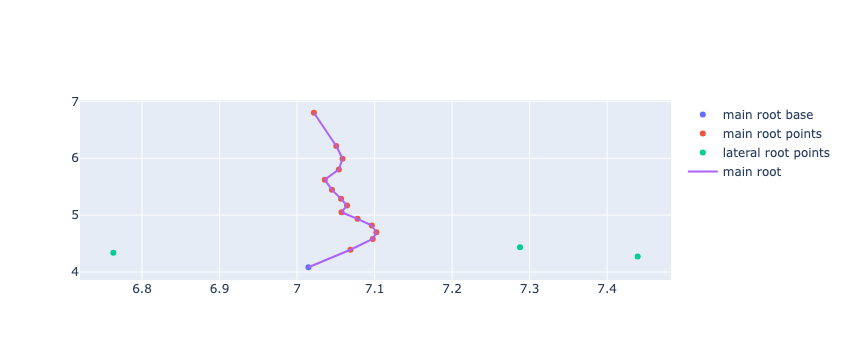

NodeDataView({0: {'label': 'main root base', 'coordinate': [7.014674, 4.083105]}, 1: {'label': 'main root', 'coordinate': (7.068931, 4.391064)}, 2: {'label': 'main root', 'coordinate': (7.097697, 4.580238)}, 3: {'label': 'main root', 'coordinate': (7.102405, 4.699361)}, 4: {'label': 'main root', 'coordinate': (7.096509, 4.817372)}, 5: {'label': 'main root', 'coordinate': (7.078003, 4.93411)}, 6: {'label': 'main root', 'coordinate': (7.057387, 5.050687)}, 7: {'label': 'main root', 'coordinate': (7.064473, 5.168109)}, 8: {'label': 'main root', 'coordinate': (7.056801, 5.286132)}, 9: {'label': 'main root', 'coordinate': (7.045027, 5.443573)}, 10: {'label': 'main root', 'coordinate': (7.03578, 5.623435)}, 11: {'label': 'main root', 'coordinate': (7.053914, 5.801408)}, 12: {'label': 'main root', 'coordinate': (7.058697, 5.991669)}, 13: {'label': 'main root', 'coordinate': (7.050602, 6.214376)}, 14: {'label': 'main root', 'coordinate': (7.021744, 6.799064)}, 15: {'label': 'lateral root tip',

In [129]:
Plant = readArborFile('084_4_C_day1.csv')
Plant.nodes.data()
Plant.edges.data()
fig = go.Figure(drawArbor(Plant))
fig.show()
Plant2 = optimalArbor(Plant, 1, .5)
fig2 = go.Figure(drawArbor(Plant2))
fig2.show()
Plant2.nodes.data()